# CNN-based Brain Tumour Detector
## Import packages
Please make sure you have all the required packages installed.

tensorflow>=2.4.0

numpy>=1.19.2

matplotlib>=3.3.2

scikit-learn>=0.24.0

tqdm>=4.50.2

In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [2]:
# print(tf.__version__)

## Data preparation (this step has been done for you)

Images in the original dataset are usually in different sizes, so we need to resize and normalise them to fit the CNN model. Depending on the images you choose to use for training your model, some other preprocessing methods (cropping, zooming, etc.) may be required.


## Split your dataset into training and validation
Validation dataset would not be used to train your network, it is normally for evaluating your model performance and choosing the best set of hyperparameters. Choose the size of your training and validation set yourself.

In [3]:
# Configure GPU memory growth (for TF2.x)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Manage directories using Python functions (delete old directories and create new train/validation subdirectories)
base_dirs = ['Train/Yes', 'Train/No', 'Val/Yes', 'Val/No']
for d in base_dirs:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d, exist_ok=True)

# Split dataset into training and validation sets
img_path = 'dataset_classification/'
train_list = []
val_list = []

for CLASS in os.listdir(img_path):
    if not CLASS.startswith('.'):
        class_dir = os.path.join(img_path, CLASS)
        all_files = os.listdir(class_dir)
        # Select only image files that have "img" in their filename
        files = [f for f in all_files if "img" in f]
        random.shuffle(files)
        num_files = len(files)
        split_idx = int(0.8 * num_files)  # 80% for training
        for i, file_name in enumerate(files):
            src_img = os.path.join(class_dir, file_name)
            # Construct segmentation file path based on naming convention
            seg_file = os.path.join(class_dir, file_name.split('_')[0] + '_seg.npy')
            if i < split_idx:
                dest_img = os.path.join('Train', CLASS, file_name)
                shutil.copy(src_img, dest_img)
                train_list.append(dest_img)
                shutil.copy(seg_file, os.path.join('Train', CLASS, file_name.split('_')[0] + '_seg.npy'))
            else:
                dest_img = os.path.join('Val', CLASS, file_name)
                shutil.copy(src_img, dest_img)
                val_list.append(dest_img)
                shutil.copy(seg_file, os.path.join('Val', CLASS, file_name.split('_')[0] + '_seg.npy'))

In [4]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers, models
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 数据生成器
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, batch_size=32, dim=(240, 240), n_channels=3,
                 n_classes=2, shuffle=True, augment=False):
        self.list_IDs = list_IDs
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size,), dtype=int)
        for i, ID in enumerate(list_IDs_temp):
            img = np.load(ID).astype(np.float32)
            img = preprocess_input(img)  # VGG16预处理
            if self.augment:
                if random.random() > 0.5:
                    img = np.fliplr(img)
            X[i] = img
            seg_path = ID.split('_')[0] + '_seg.npy'
            seg = np.load(seg_path)
            y[i] = 1 if np.sum(seg) > 0 else 0
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)
train_generator = DataGenerator(train_list, augment=True)
validation_generator = DataGenerator(val_list)

# 构建模型
img_size = (240, 240)
num_classes = 2
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(240, 240, 3))
for layer in base_model.layers[:-12]:  # 冻结除最后12层外的所有层
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    # layers.Dense(256, activation='relu'),
    # layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# 训练模型
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-9)

history = model.fit(
    train_generator,
    epochs=80,  # 增加训练轮数
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/80
14/14 [==============================] - 32s 1s/step - loss: 0.9986 - accuracy: 0.5960 - val_loss: 0.4882 - val_accuracy: 0.7396 - lr: 1.0000e-05
Epoch 2/80
14/14 [==============================] - 7s 464ms/step - loss: 0.6794 - accuracy: 0.6272 - val_loss: 0.4629 - val_accuracy: 0.7812 - lr: 1.0000e-05
Epoch 3/80
14/14 [==============================] - 6s 431ms/step - loss: 0.6070 - accuracy: 0.6674 - val_loss: 0.4656 - val_accuracy: 0.7917 - lr: 1.0000e-05
Epoch 4/80
14/14 [==============================] - 6s 410ms/step - loss: 0.5950 - accuracy: 0.7009 - val_loss: 0.4999 - val_accuracy: 0.7604 - lr: 1.0000e-05
Epoch 5/80
14/14 [==============================] - 6s 410ms/step - loss: 0.5539 - accuracy: 0.7321 - val_loss: 0.4694 - val_accuracy: 0.7812 - lr: 1.0000e-05
Epoch 6/80
14/14 [==============================] - 6s 411ms/step - loss: 0.5744 - accuracy: 0.6942 - val_loss: 0.4566 - val_accuracy: 0.7917 - lr: 1.0000e-05
Epoch 7/80
14/14 [==============================

## Plot images
Plot some sample images here.

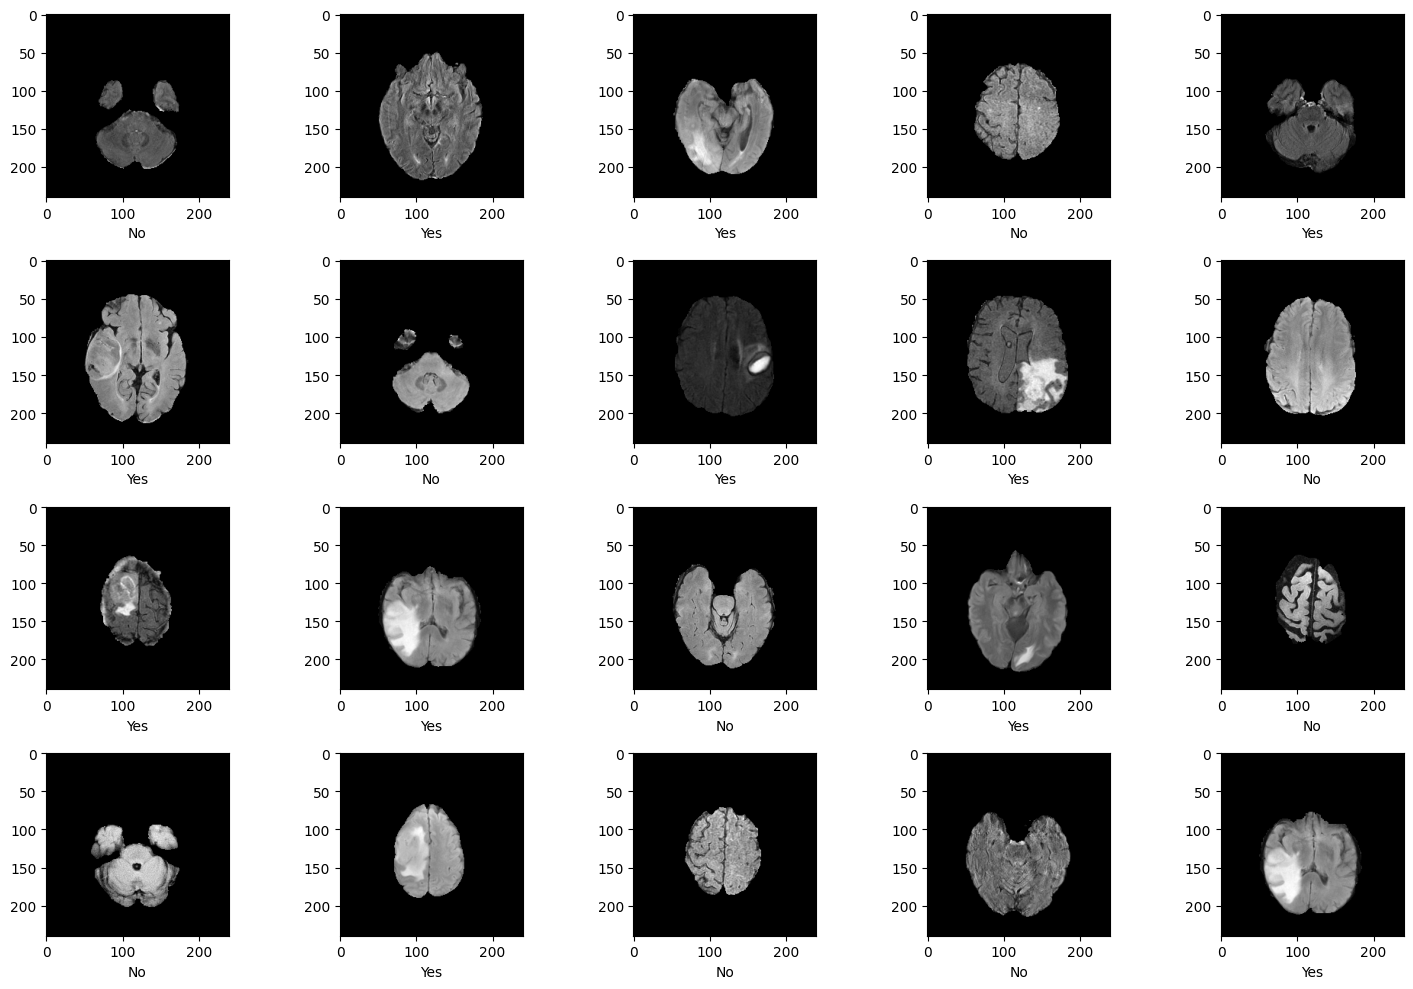

In [5]:
def plot_samples(img_path,n=20):
    files_list = []
    labels_list = []
    for path, subdirs, all_files in os.walk(img_path):
        files = [item for item in all_files if "img" in item]
        for name in files:
            files_list.append(os.path.join(path, name))
            labels_list.append(path.split('/')[1])
    imgs_lbls = list(zip(files_list, labels_list))
    random.shuffle(imgs_lbls)
    files_list, labels_list = zip(*imgs_lbls)
    j = 5
    i = int(n/j)
    plt.figure(figsize=(15,10))
    k = 1
    for file, lbl in zip(files_list[:n], labels_list[:n]):
        img = np.load(file)
        plt.subplot(i,j,k)
        plt.imshow(img[:,:,0], cmap='gray')
        plt.xlabel(lbl)
        k += 1
    plt.tight_layout()
    plt.show()
    
plot_samples(img_path)

## Train-time data augmentation
Generalizability is crucial to a deep learning model and it refers to the performance difference of a model when evaluated on the seen data (training data) versus the unseen data (testing data). Improving the generalizability of these models has always been a difficult challenge. 

<img src="files/img.jpg">


**Data Augmentation** is an effective way of improving the generalizability, because the augmented data will represent a more comprehensive set of possible data samples and minimizing the distance between the training and validation/testing sets.

There are many data augmentation methods you can choose in this projects including rotation, shifting, flipping, etc.

You are encouraged to try different augmentation method to get the best classification accuracy.

**Question**

Applying data augmentation to medical images may sometimes make the images uninterpretable to human. For instance, a heart may not look like a heart after shearing the image. Would training the model with these uninterpretable images helpful to improving the model performance? Why do you think it is helpful/not helpful?

## Get the data generator ready

You may change the batch size of your training data here. A large batch size or even a batch size that equals to the entire dataset is more likely to get your model to the convergence to the global optima of the loss function, but this is at the cost of computational efficiency and sometimes large batch size would lead to a bad model generalisation. 

There is always a trade-off between large and small batch size. Choose a reasonable batch size here to get the best model performance.

In [6]:
# # 4. Define data generator with normalization and optional data augmentation
# class DataGenerator(keras.utils.Sequence):
#     def __init__(self, list_IDs, batch_size=32, dim=(240, 240), n_channels=3,
#                  n_classes=2, shuffle=True, augment=False):
#         self.list_IDs = list_IDs
#         self.batch_size = batch_size
#         self.dim = dim
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.shuffle = shuffle
#         self.augment = augment
#         self.on_epoch_end()
    
#     def __len__(self):
#         return int(np.floor(len(self.list_IDs) / self.batch_size))
    
#     def __getitem__(self, index):
#         indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
#         list_IDs_temp = [self.list_IDs[k] for k in indexes]
#         X, y = self.__data_generation(list_IDs_temp)
#         return X, y
    
#     def on_epoch_end(self):
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle:
#             np.random.shuffle(self.indexes)
    
#     def __data_generation(self, list_IDs_temp):
#         X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
#         y = np.empty((self.batch_size,), dtype=int)
#         for i, ID in enumerate(list_IDs_temp):
#             # Load image data and normalize to [0, 1]
#             img = np.load(ID).astype(np.float32) / 255.0
#             if self.augment:
#                 # Example: random horizontal flip
#                 if random.random() > 0.5:
#                     img = np.fliplr(img)
#             X[i] = img
#             # Determine label based on the segmentation file:
#             # If the sum of tumor pixels is greater than 0, label = 1, else label = 0
#             seg_path = ID.split('_')[0] + '_seg.npy'
#             seg = np.load(seg_path)
#             y[i] = 1 if np.sum(seg) > 0 else 0
#         return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

# train_generator = DataGenerator(train_list, augment=True)
# validation_generator = DataGenerator(val_list)

## Load the backbone model

To extract the features from the dataset, a backbone network is used here. Initially, VGG16 is used here as an example.

To achieve the best classification accuracy, you are encouraged to try different models. A list of models you can try is given at https://keras.io/api/applications/. Remember to update the **Preparing your environment** and **this** part to use a different backbone model, for instance, to use the ResNet50 as the backbone network, change 'from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input' into 'from tensorflow.keras.applications.resnet_v2 import ResNet50, preprocess_input'

More details about how to created VGG16 using Python: https://github.com/keras-team/keras/blob/v3.8.0/keras/src/applications/vgg16.py

These models are pretrained on ImageNet dataset for classification task and you can choose to finetune the pretrained network (transfer learning: https://papers.nips.cc/paper/5347-how-transferable-are-features-in-deep-neural-networks.pdf) or train it from the scratch for the tumour detection task.

VGG16: https://arxiv.org/pdf/1409.1556

ResNet: https://arxiv.org/abs/1512.03385

DenseNet: https://arxiv.org/abs/1608.06993

**Question**

What are the advantages and disadvantages of finetuning a model for tumour detection?

In [7]:
# # Build the model
# img_size = (240, 240)
# num_classes = 2

# # If you want to use pretrained weights, change weights to 'imagenet'
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=img_size + (3,))

In [8]:
# # Build the model
# #Don't run it!!!
# img_size = (240, 240)
# num_classes = 2

# # If you want to use pretrained weights, change weights to 'imagenet'
# base_model = keras.applications.EfficientNetB4(
#     include_top=False,
#     weights=None,
#     input_tensor=None,
#     input_shape=img_size + (3,),
#     pooling=None,
#     classes=2,
#     classifier_activation="softmax",
#     # name="efficientnetb4",
# )

## Build the model for tumour detection

A classifier is added to the backbone network here. The loss function used to train the model is binary cross entropy (details can be found at https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class and https://machinelearningmastery.com/cross-entropy-for-machine-learning/). 

The optimizer used here is ADAM (https://arxiv.org/abs/1412.6980) and you can leave it unchanged.

In [9]:
# model = keras.Sequential([
#     base_model,
#     layers.Flatten(),
#     layers.Dropout(0.5),
#     layers.Dense(num_classes, activation='softmax')  # Use softmax activation for one-hot labels
# ])

# # uncomment here if you want to finetune the top layer(classifier) of a pretrained network only. 
# model.layers[0].trainable = False

# model.compile(
#     loss='categorical_crossentropy',
#     optimizer=Adam(learning_rate=1e-4),
#     metrics=['accuracy']
# )

# model.summary()

## Train the model
The early stopping would stop the training process when a pre-defined metric stops improving. More details can be found at https://keras.io/api/callbacks/early_stopping/.

In [10]:
# # Define callbacks: EarlyStopping and ModelCheckpoint
# early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
# checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

# # Train the model
# num_epochs = 20  # Adjust the number of epochs as needed, it was 20 at first
# history = model.fit(
#     train_generator,
#     epochs=num_epochs,
#     validation_data=validation_generator,
#     callbacks=[early_stopping, checkpoint]
# )

## Plot training result

**Question**

What causes the gap between training accuracy/loss and test accuracy/loss? How do you reduce the gap between training accuracy/loss and test accuracy/loss?

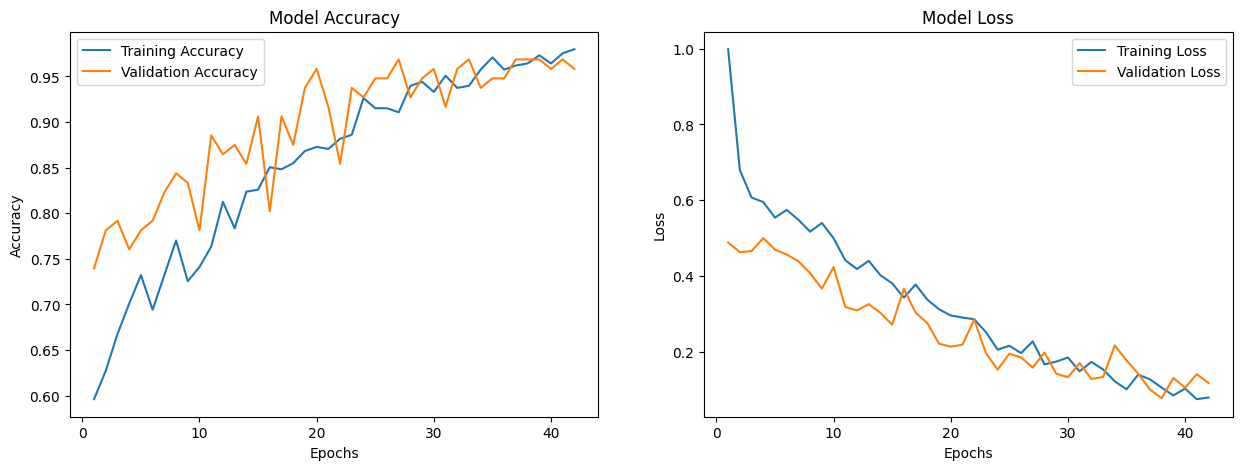

In [11]:
# Plot training and validation accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

## Save your trained model
If you feel your model has been trained to convergence, save it here.

In [12]:
model.save('trained_model.h5')
# model.save('trained_model.keras')

## Test the model
Test your trained model here.

In [13]:
test_dir = 'Val/'
#load your model here
model = load_model('trained_model.h5')
test_list = []
for CLASS in os.listdir(test_dir):
    if not CLASS.startswith('.'):
        all_files = os.listdir(test_dir + CLASS)
        files = [item for item in all_files if "img" in item]
        for file_name in files:
            test_list.append(test_dir + CLASS + '/' + file_name)
test_generator = DataGenerator(test_list, batch_size=1)

predictions = []
y_test = []
for i in range(test_generator.__len__()):
    x_test, y = test_generator.__getitem__(i)
    y_test.append(y[0][1])
    prediction = model.predict(x_test)
    predictions.append(np.int32(prediction[0][1]>0.5))
accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

1/1 [==============================] - 0s 26ms/step
Test Accuracy = 0.97
